# Online Retail Customer Segmentation using RFM and K-Means

This notebook demonstrates a customer segmentation analysis using the RFM (Recency, Frequency, Monetary) method and K-Means clustering on an online retail dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_excel("Online Retail.xlsx")  # loads the uploaded file
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Drop nulls in CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

/tmp/ipython-input-4055944967.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [6]:
import datetime as dt

# Reference date (e.g., 1 day after last invoice date)
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum'                                   # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


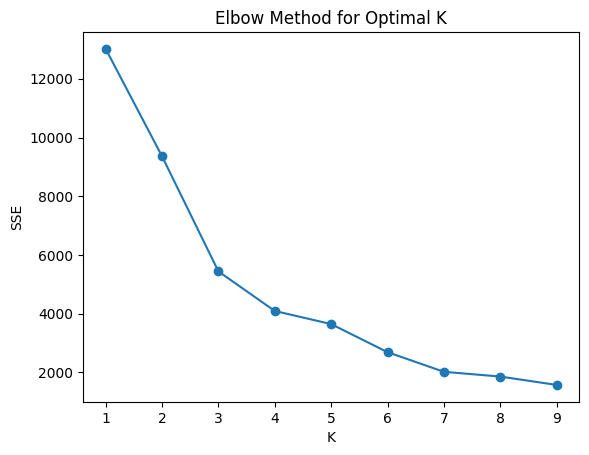

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Find optimal K (optional elbow)
import matplotlib.pyplot as plt

sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 10), sse, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,0
1,12347.0,2,7,4310.00,3
2,12348.0,75,4,1797.24,3
3,12349.0,19,1,1757.55,3
4,12350.0,310,1,334.40,1


         Recency  Frequency  Monetary
Cluster                              
0           15.7       22.0   12453.2
1          248.6        1.6     478.1
2            7.4       82.7  127338.3
3           43.9        3.7    1349.7


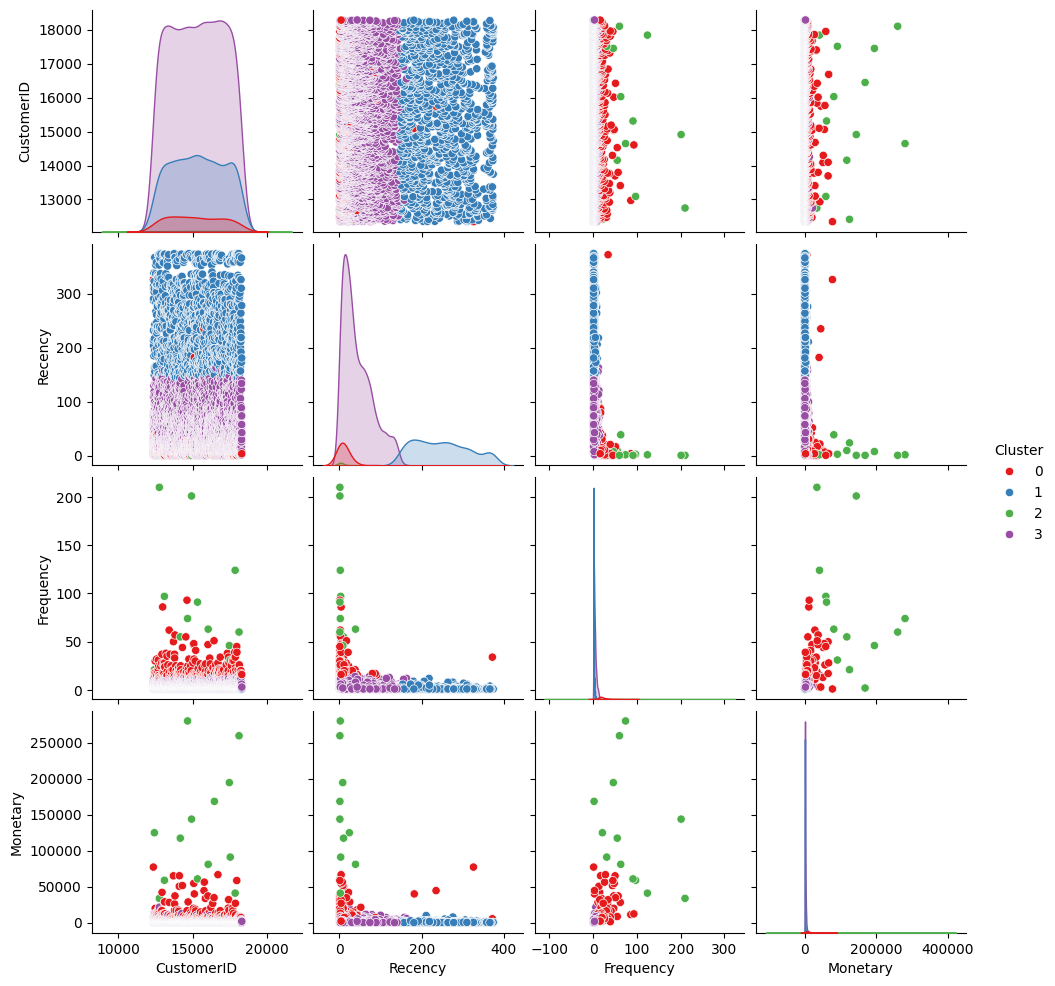

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cluster profile
cluster_avg = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print(cluster_avg)

# Plot
sns.pairplot(rfm, hue='Cluster', palette='Set1')
plt.show()

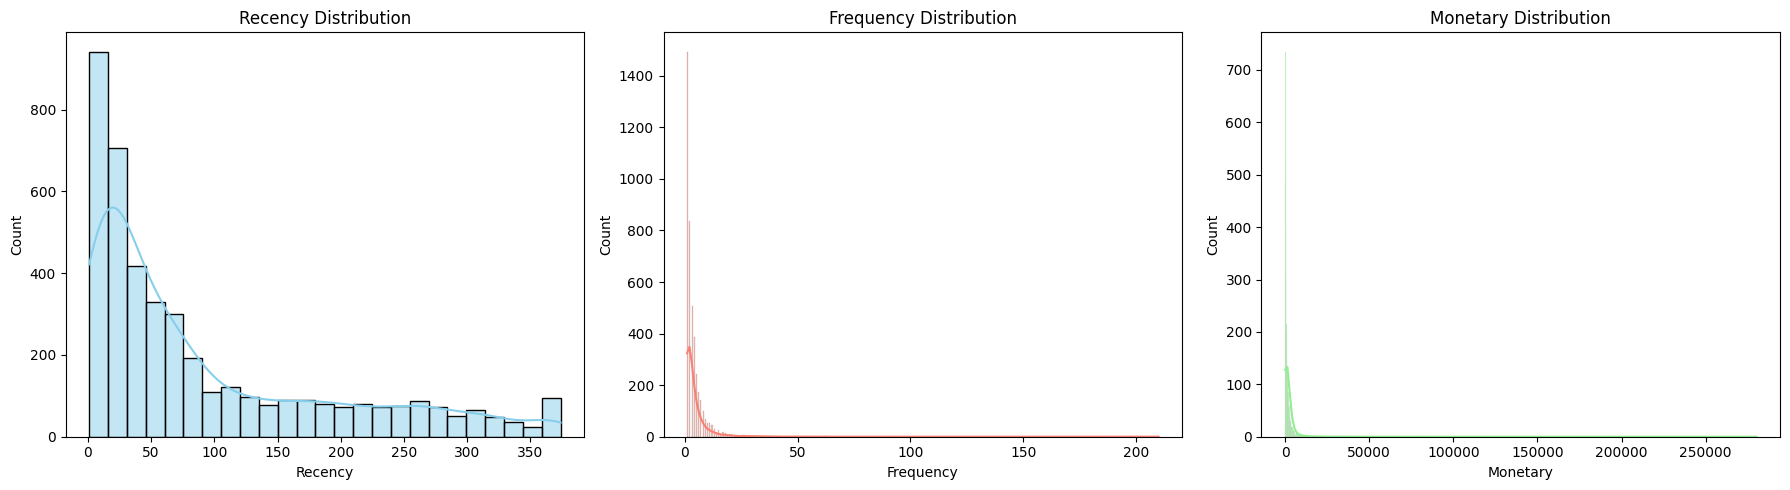

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], ax=axes[0], kde=True, color='skyblue')
sns.histplot(rfm['Frequency'], ax=axes[1], kde=True, color='salmon')
sns.histplot(rfm['Monetary'], ax=axes[2], kde=True, color='lightgreen')
axes[0].set_title('Recency Distribution')
axes[1].set_title('Frequency Distribution')
axes[2].set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

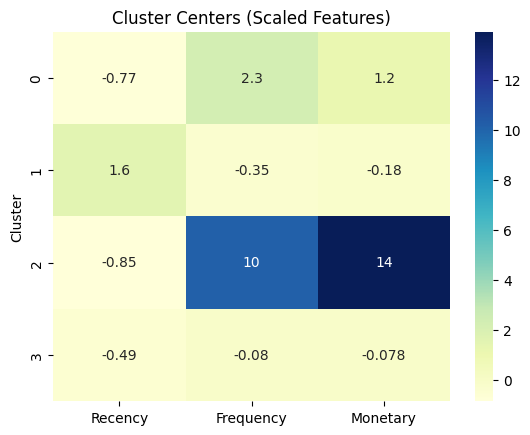

In [11]:
import numpy as np

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df['Cluster'] = rfm['Cluster']

cluster_centers = rfm_scaled_df.groupby('Cluster').mean()
sns.heatmap(cluster_centers, annot=True, cmap="YlGnBu")
plt.title("Cluster Centers (Scaled Features)")
plt.show()

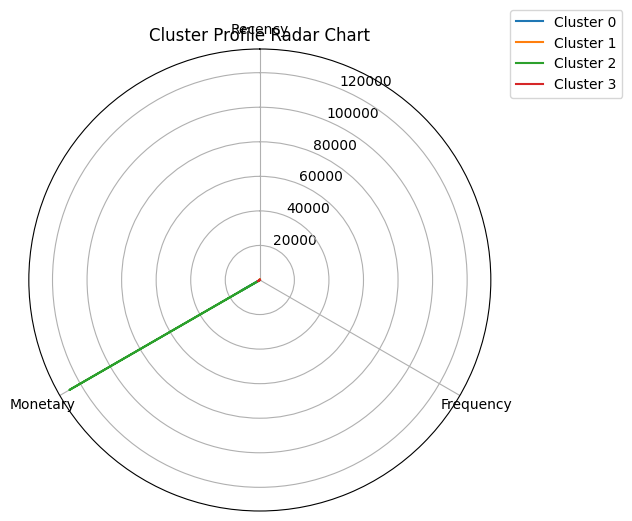

In [12]:
import matplotlib.pyplot as plt
import numpy as np

cluster_avg = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

labels = cluster_avg.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, row in cluster_avg.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Cluster Profile Radar Chart')
plt.show()

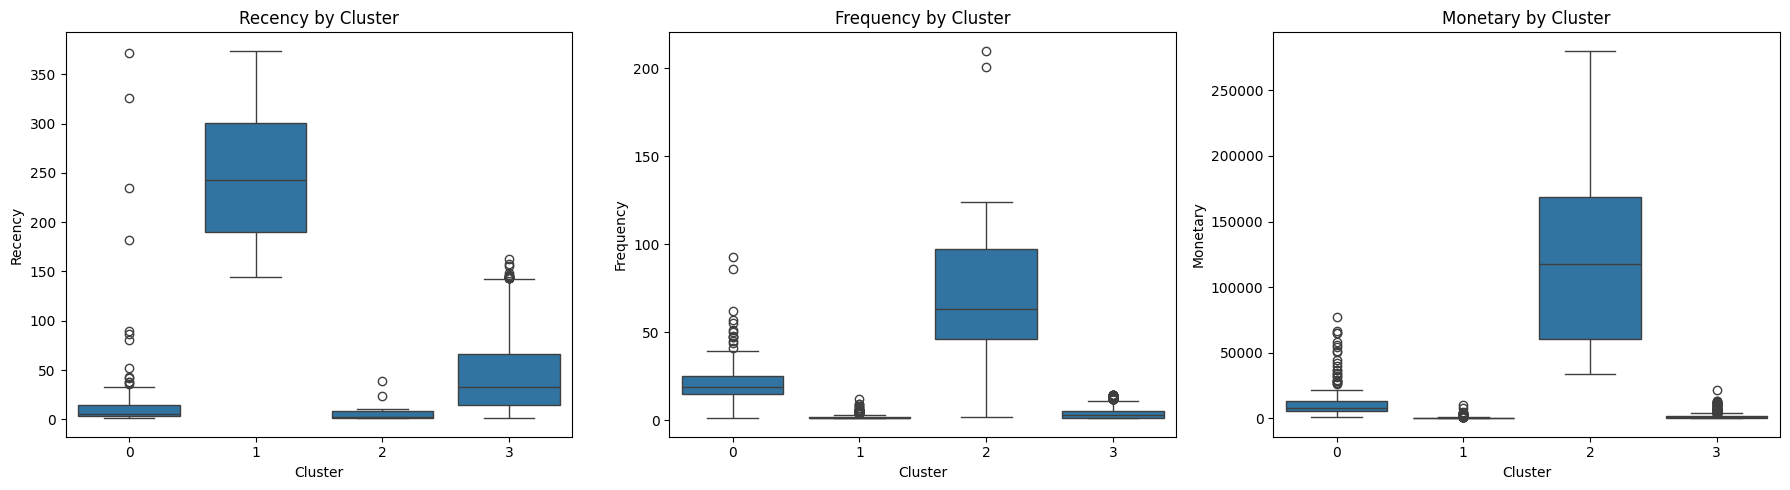

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0])
sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1])
sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2])
axes[0].set_title('Recency by Cluster')
axes[1].set_title('Frequency by Cluster')
axes[2].set_title('Monetary by Cluster')
plt.tight_layout()
plt.show()

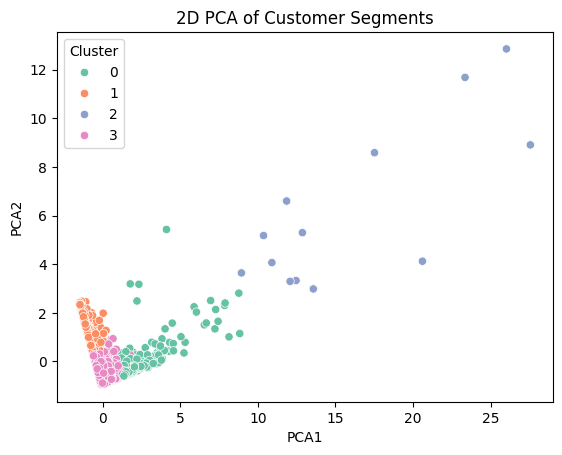

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='Set2')
plt.title("2D PCA of Customer Segments")
plt.show()

## Customer Segmentation Analysis Report

Based on the RFM (Recency, Frequency, Monetary) analysis and K-Means clustering, the following customer segments have been identified:

### Cluster 0: High-Spending, Frequent, Recent Customers
*   **Characteristics:** These customers have the lowest recency (15.7 days), highest frequency (22.0), and high monetary value (£12453.2).
*   **Description:** This segment represents your most valuable customers. They are recent, frequent, and high spenders.
*   **Strategy:** Prioritize retention and engagement strategies for this segment. Consider loyalty programs, exclusive offers, and personalized communication to maintain their high level of engagement.

### Cluster 1: Low-Spending, Infrequent, Less Recent Customers
*   **Characteristics:** These customers have the highest recency (248.6 days), lowest frequency (1.6), and lowest monetary value (£478.1).
*   **Description:** This segment likely includes inactive or churned customers.
*   **Strategy:** Focus on re-engagement strategies for potentially salvageable customers or shift focus to acquiring new customers similar to the more valuable segments. Analyze the reasons for their inactivity.

### Cluster 2: Very High-Spending, Very Frequent, Very Recent Customers
*   **Characteristics:** This is a small but extremely valuable cluster with very low recency (7.4 days), very high frequency (82.7), and exceptionally high monetary value (£127338.3).
*   **Description:** These are likely your VIP or platinum customers.
*   **Strategy:** Provide special attention, dedicated support, and exclusive benefits to this segment. Nurture these relationships to ensure continued high value.

### Cluster 3: Medium-Spending, Low Frequency, Medium Recency Customers
*   **Characteristics:** This is the largest cluster with medium recency (43.9 days), low frequency (3.7), and medium monetary value (£1349.7).
*   **Description:** This segment represents a significant portion of your customer base with moderate engagement.
*   **Strategy:** Implement strategies to increase their frequency and monetary value. This could include targeted promotions, cross-selling or upselling initiatives, and personalized product recommendations.

### Conclusion

The RFM analysis and K-Means clustering have successfully segmented the customer base into distinct groups with varying purchasing behaviors. These insights can be used to develop targeted marketing campaigns, improve customer relationship management, and optimize resource allocation for maximum impact.